In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os
from warnings import filterwarnings
filterwarnings('ignore')

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2024-03-21 23:01:33.391536: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
2.12.0


### Just playing around with tensorflow.  I don't believe there are enough observations here to warrant a deep neural net.

In [2]:
data = pd.read_csv('../notebooks/data/merged_inputed_data.csv')

data.shape

(1305, 358)

In [3]:
data.columns

Index(['patdeid', 'meds_methadone_0', 'meds_buprenorphine_0',
       'meds_methadone_1', 'meds_buprenorphine_1', 'meds_methadone_2',
       'meds_buprenorphine_2', 'meds_methadone_3', 'meds_buprenorphine_3',
       'meds_methadone_4',
       ...
       'race_amer_ind', 'race_Asian', 'race_Black', 'race_pacific_isl',
       'race_White', 'medication', 'total_visits', 'TNT', 'CNT', 'responder'],
      dtype='object', length=358)

### We have a wide dataset with over 358 columns
- We will subset the data to include, medication doses and urine drug screens
- The benchmark model showed loss at around 20% with a limited group of features, namely the urine drug screens
- Let's see if the loss improves, by adding the medication doses

In [4]:
# subset the medication doses
# add patdeid as the primary key to merge other columns

meds = data[[col for col in data.columns if col.startswith('meds')]+['patdeid']]

# subset the lab results 
# add patdeid as the primary key to merge other columns
labs = data[[col for col in data.columns if col.startswith('test') and 'Opiate300' in col]+['patdeid']]

# create outcome dataframe
outcome = data[['patdeid','responder']]

# merge dfs with functools
from functools import reduce
dfs = [meds, labs, outcome] 
merged = reduce(lambda left,right: pd.merge(left,right,on='patdeid'), dfs)

print('Total features in the dataset:',merged.shape[1])
print('Total patient observations:',merged.shape[0])
merged[:5] #show the head of the df                  

Total features in the dataset: 77
Total patient observations: 1305


,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,...,test_Opiate300_16,test_Opiate300_17,test_Opiate300_18,test_Opiate300_19,test_Opiate300_20,test_Opiate300_21,test_Opiate300_22,test_Opiate300_23,test_Opiate300_24,responder
0,0.0,8.0,0.0,160.0,0.0,320.0,0.0,192.0,0.0,384.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,8.0,0.0,48.0,0.0,48.0,0.0,60.0,0.0,48.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0
2,30.0,0.0,170.0,0.0,310.0,0.0,420.0,0.0,360.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
3,0.0,16.0,0.0,152.0,0.0,192.0,0.0,160.0,0.0,64.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0
4,0.0,16.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


In [5]:
# look for class imbalance
merged.responder.value_counts(normalize=True)

responder
0    0.787739
1    0.212261
Name: proportion, dtype: float64

### There is a class inbalance, clearly.  We won't do anything now, let's see how the training works out first. 

In [6]:
train_dataset = merged.sample(frac=0.75, random_state=1)

print('number of observations in the training set:',len(train_dataset))


number of observations in the training set: 979


In [7]:
# create the 
test_dataset = merged.drop(train_dataset.index)

print('number of observations in the test set:',len(test_dataset))


number of observations in the test set: 326


In [8]:
# train test split
x_train, y_train = train_dataset.iloc[:,:-1], train_dataset.iloc[:, -1]
x_test, y_test = test_dataset.iloc[:, :-1], test_dataset.iloc[:, -1]

In [9]:
# convert to tensors
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

In [10]:
# sns.pairplot(train_dataset.iloc[:, 0:26], hue = 'medication', diag_kind='kde');
# There are too many columns for the pair plot to work

In [11]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

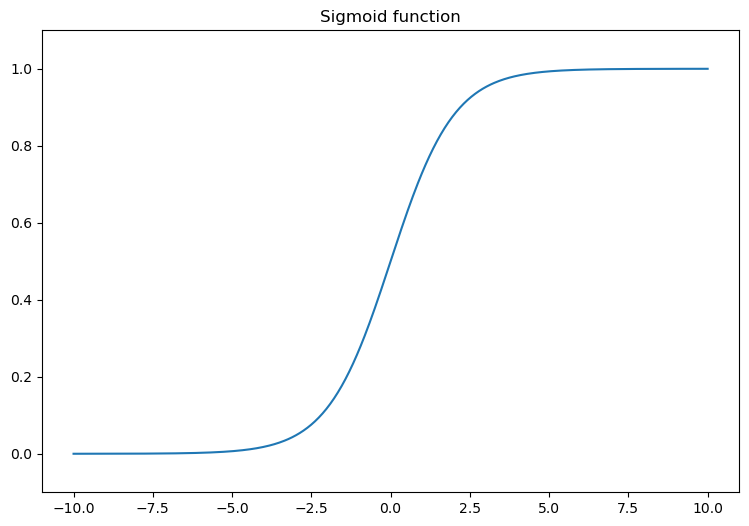

In [12]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");

In [13]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

In [14]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

In [15]:
log_reg = LogisticRegression()

In [16]:
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()

array([0.00833135, 0.0017868 , 0.00995247, 0.9999725 , 0.9999778 ],
      dtype=float32)

In [17]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

In [18]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [20]:
# Set training parameters
epochs = 1000
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 0.437
Epoch: 100, Training log loss: 0.242
Epoch: 200, Training log loss: 0.213
Epoch: 300, Training log loss: 0.206
Epoch: 400, Training log loss: 0.199
Epoch: 500, Training log loss: 0.192
Epoch: 600, Training log loss: 0.187
Epoch: 700, Training log loss: 0.187
Epoch: 800, Training log loss: 0.184
Epoch: 900, Training log loss: 0.183


### Adding the med features created a 4% improvment in loss, compared to the benchmark model

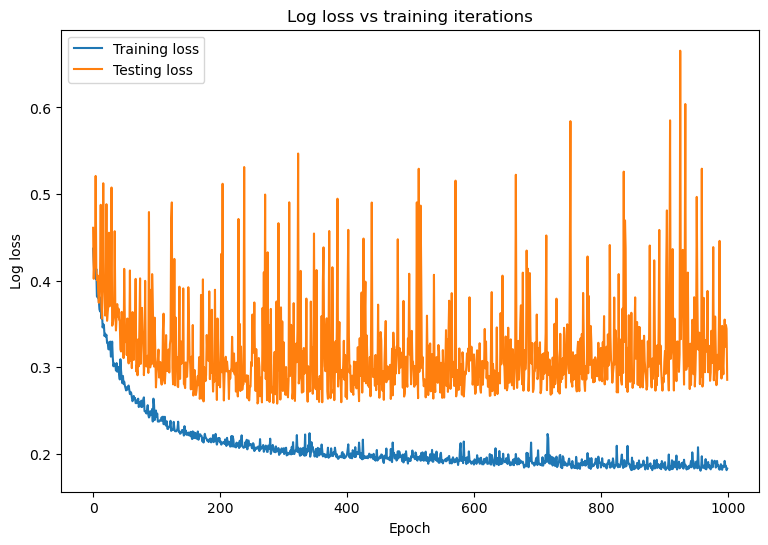

In [21]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

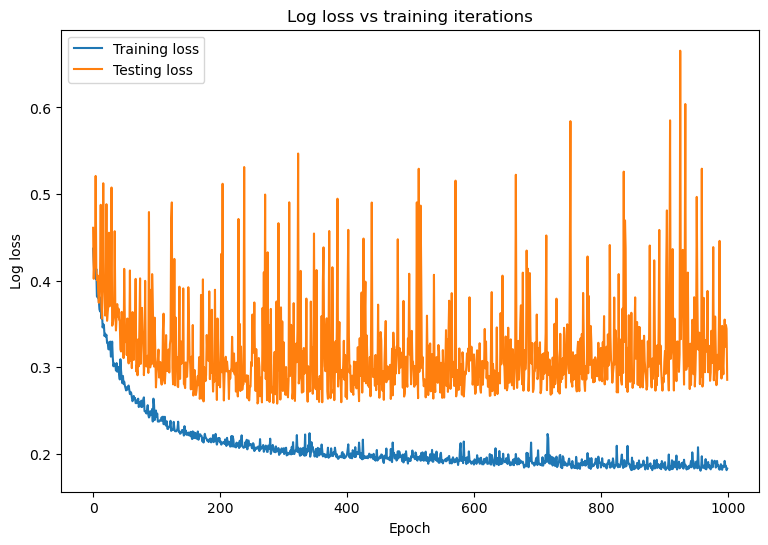

In [22]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

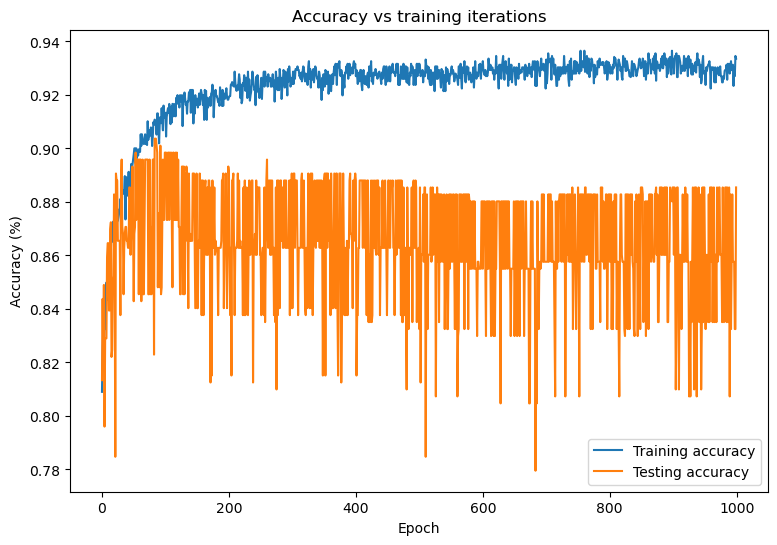

In [23]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [24]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 0.183
Final testing log Loss: 0.285


In [25]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.934
Final testing accuracy: 0.885


In [26]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

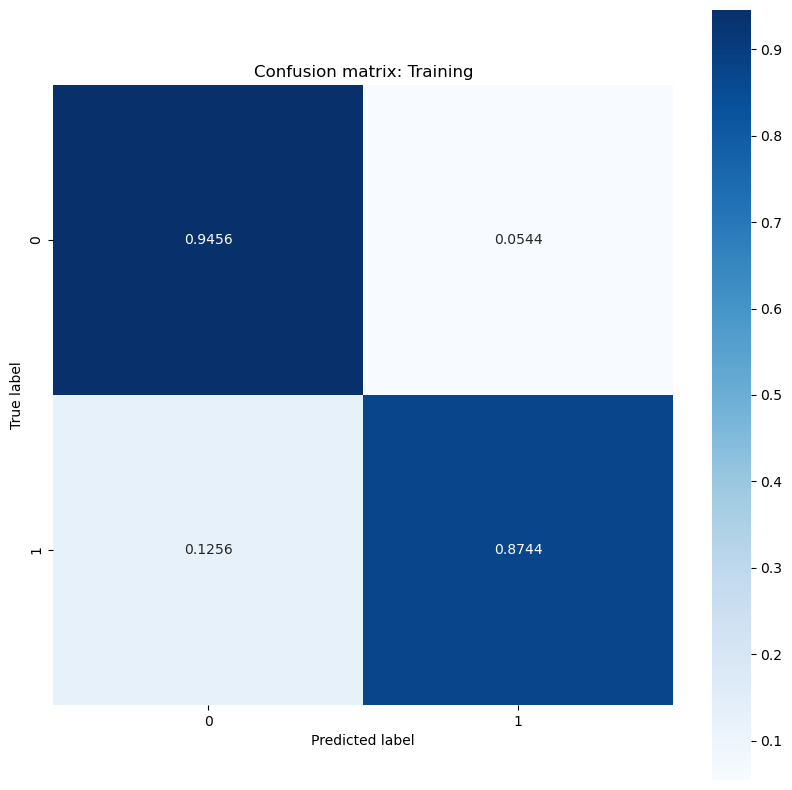

In [27]:
show_confusion_matrix(y_train, train_classes, 'Training')

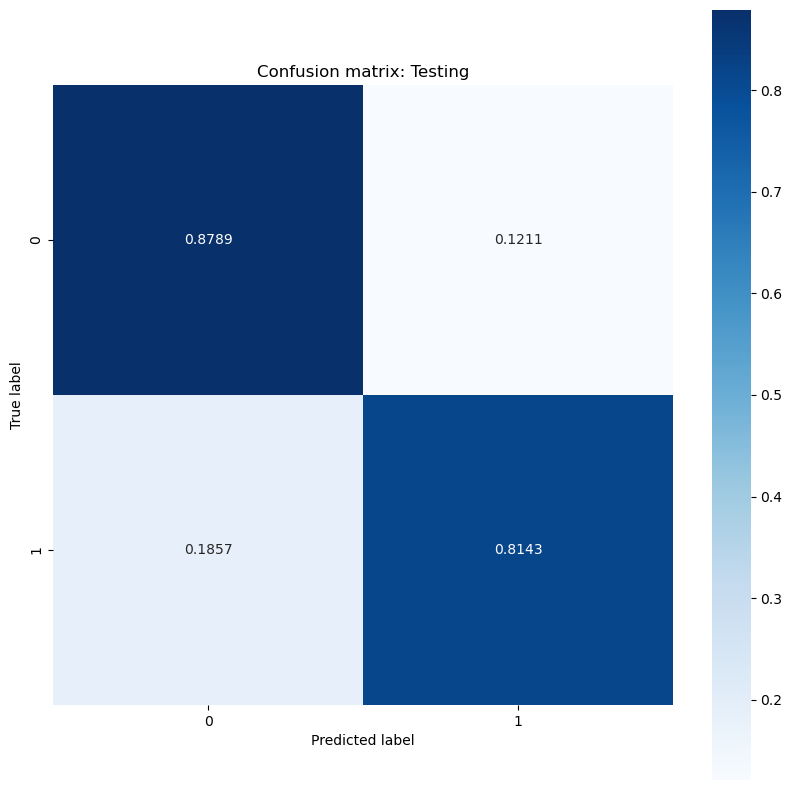

In [28]:
show_confusion_matrix(y_test, test_classes, 'Testing')

In [29]:
class ExportModule(tf.Module):
  def __init__(self, model, norm_x, class_pred):
    # Initialize pre- and post-processing functions
    self.model = model
    self.norm_x = norm_x
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
  def __call__(self, x):
    # Run the `ExportModule` for new data points
    x = self.norm_x.norm(x)
    y = self.model(x, train=False)
    y = self.class_pred(y)
    return y

In [30]:
# save model weigts in export variable
log_reg_export = ExportModule(model=log_reg,
                              norm_x=norm_x,
                              class_pred=predict_class)

In [31]:
# create directory under notebooks called "model_weights"
os.makedirs('../notebooks/model_weights', exist_ok=True)

# save the model weights
export_path = '../notebooks/model_weights'
export_module_dir = tempfile.mkdtemp()
tf.saved_model.save(log_reg_export, export_module_dir)

# move the model weights to the model_weights directory
!mv {export_module_dir}/* {export_path}

INFO:tensorflow:Assets written to: /var/folders/f1/dmgdbt5j5nb5ht5_vfxmr8gm0000gn/T/tmpuqxnt69h/assets
mv: rename /var/folders/f1/dmgdbt5j5nb5ht5_vfxmr8gm0000gn/T/tmpuqxnt69h/variables to ../notebooks/model_weights/variables: Directory not empty


In [ ]:
log_reg_loaded = tf.saved_model.load(export_path)
test_preds = log_reg_loaded(x_test)
test_preds[:10].numpy()